# Desafío - Mecanismos de Votación
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Mecanismos de Votación.

## Requerimientos
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39.797 registros, donde cada uno representa características del artículo publicado en el sitio web.

Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal. Los artículos registrados son de <a href="https://www.mashable.com/">esta página web</a>.

Más información sobre los atributos se puede encontrar en el archivo `OnlineNewsPopularity.names`.

### Ejercicio 1 - Preparación del Ambiente de Trabajo
- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función `grid_plot_batch` que se encuentra en el archivo `helpers.py`.
```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations` que se encuentra en el archivo `helpers.py`. Para todos aquellos atributos que tengan una correlación de .8 o más, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos con los siguientes pasos:
    - Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable `shares` posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8 (una del par). Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
# Utilice esta celda para importar los módulos necesarios y el set de datos que está en OnlineNewsPopularity/OnlineNewsPopularity.csv
# Importaciones clasicas de analicis, pre procesamiento y graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learninr
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Funsiones espesifixcas para este desafio
import helpers2 as gfx

# Otras importaciones nesesarias, instancias y configuraciones
import re
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
rep_seed = 15820

In [2]:
df = pd. read_csv('Datasets/OnlineNewsPopularity.csv')
df.sample(5, random_state = 15820)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
39397,http://mashable.com/2014/12/22/kangaroo-drone/,14.0,9.0,332.0,0.306452,1.0,0.385714,0.0,0.0,8.0,...,0.100000,0.5,-0.175000,-0.2,-0.150000,0.000000,0.000000,0.500000,0.000000,2400
10591,http://mashable.com/2013/07/27/healthier-child...,530.0,14.0,408.0,0.550251,1.0,0.711934,3.0,3.0,10.0,...,0.100000,1.0,-0.248512,-0.5,-0.050000,0.333333,0.250000,0.166667,0.250000,1200
18172,http://mashable.com/2013/12/31/dell-ad-private...,373.0,12.0,354.0,0.565868,1.0,0.672897,18.0,13.0,0.0,...,0.100000,1.0,-0.257778,-0.4,-0.133333,0.454545,0.136364,0.045455,0.136364,1400
23664,http://mashable.com/2014/04/16/zoey-and-jasper/,266.0,13.0,715.0,0.441926,1.0,0.678571,7.0,0.0,2.0,...,0.033333,0.7,-0.270313,-0.8,-0.100000,1.000000,0.000000,0.500000,0.000000,489
2109,http://mashable.com/2013/02/12/mophie-juice-pa...,695.0,13.0,410.0,0.500000,1.0,0.634361,4.0,3.0,6.0,...,0.100000,0.6,-0.247619,-0.6,-0.050000,0.333333,0.250000,0.166667,0.250000,2400


In [3]:
# Utilice esta celda para aplicar el procesamiento indicado en el enunciado (implemente el mismo código)
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex = '^n_', axis = 1)
channel = df.filter(regex = '^data_', axis = 1)
days = df.filter(regex = re.compile("weekday|weekend"), axis = 1)
sentiments = df.filter(regex = re.compile("negative|positive|subjectivity"), axis = 1)
lda = df.filter(regex = '^LDA_\d', axis = 1)
keywords = df.filter(regex = '^kw_', axis = 1)

In [4]:
qnty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   n_tokens_title            39644 non-null  float64
 1   n_tokens_content          39644 non-null  float64
 2   n_unique_tokens           39644 non-null  float64
 3   n_non_stop_words          39644 non-null  float64
 4   n_non_stop_unique_tokens  39644 non-null  float64
dtypes: float64(5)
memory usage: 1.5 MB


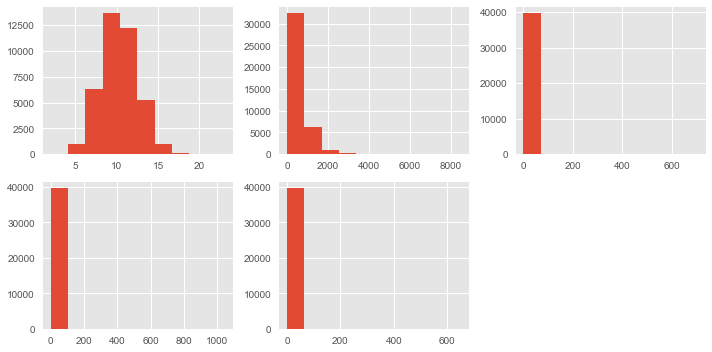

In [5]:
# Utilice esta celda para realizar los gráficos llamando a la función helpers.grid_plot_batch para qnty
#    - Se recomienda setear antes plt.figure(figsize=(10, 5))
#    - Los argumentos de la función en este caso son qnty, 3, plt.hist
plt.figure(figsize = (10, 5))
gfx.grid_plot_batch(qnty, 3, plt.hist)

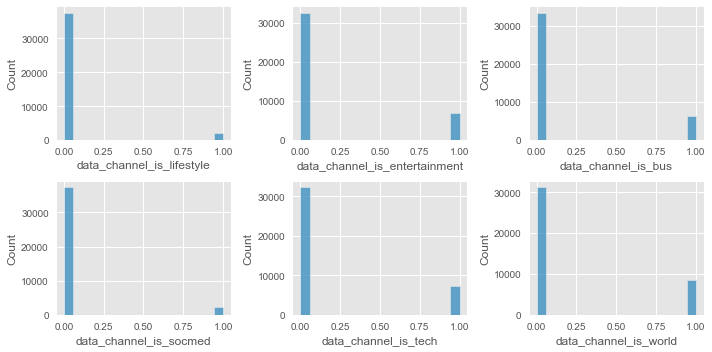

In [6]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para channel.
# Como tercer argumento utilice sns.countplot
# no funciona con sns.countplot
plt.figure(figsize = (10, 5))
gfx.grid_plot_batch(channel, 3, sns.histplot)

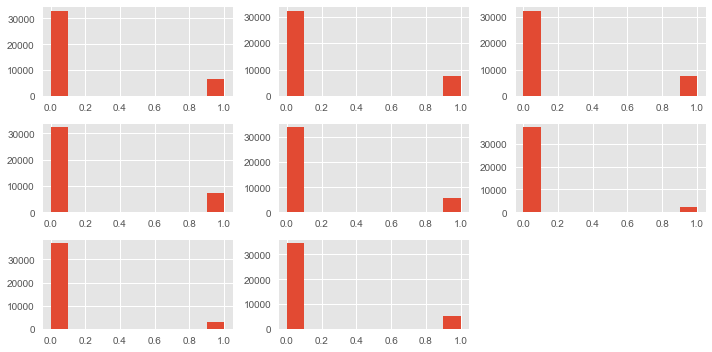

In [7]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para days (variable categórica).
plt.figure(figsize = (10, 5))
gfx.grid_plot_batch(days, 3, plt.hist)

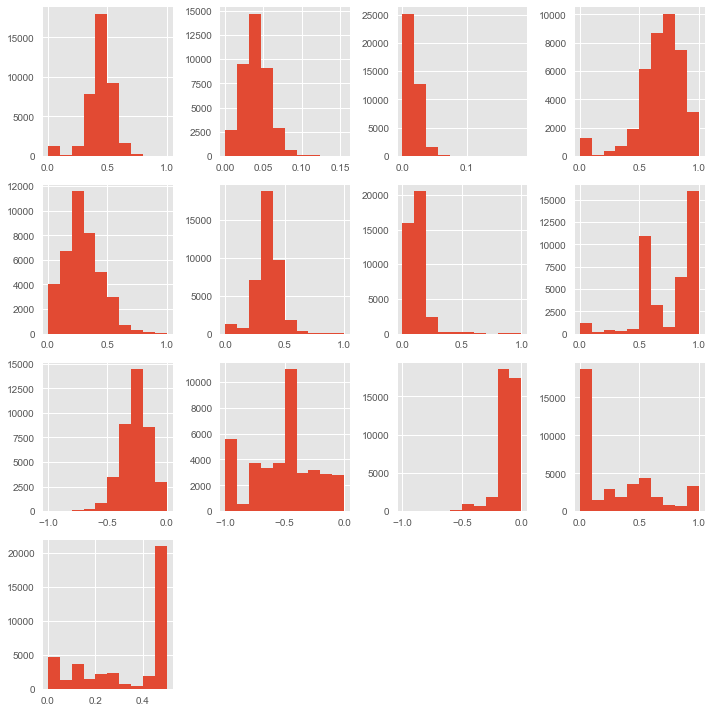

In [8]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para sentiments (variable continua).
plt.figure(figsize = (10, 10))
gfx.grid_plot_batch(sentiments, 4, plt.hist)

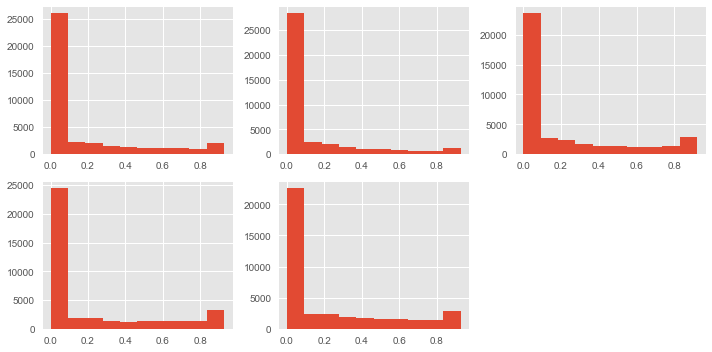

In [9]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para lda (variable continua).
plt.figure(figsize = (10, 5))
gfx.grid_plot_batch(lda, 3, plt.hist)

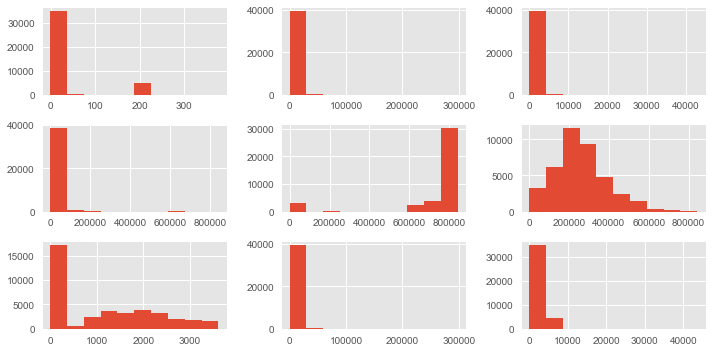

In [10]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para keywords.
plt.figure(figsize = (10, 5))
gfx.grid_plot_batch(keywords, 3, plt.hist)

In [11]:
# Utilice esta celda para identificar correlaciones altas con helpers.identify_high_correlations, asignando su retorno a df_correlaciones
df_correlaciones = gfx.identify_high_correlations(df)
df_correlaciones

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2159,is_weekend,weekday_is_sunday,0.701648
2196,LDA_00,data_channel_is_bus,0.774651


In [12]:
# Para todos aquellos atributos que tengan una correlación de .8 o más, reporte sus nombres.
df_correlaciones[(df_correlaciones['value'] >= 0.8)][['variable', 'var2']].reset_index(drop = True)

,variable,var2
0,n_non_stop_words,n_unique_tokens
1,n_non_stop_unique_tokens,n_unique_tokens
2,n_non_stop_unique_tokens,n_non_stop_words
3,kw_avg_min,kw_max_min
4,kw_avg_avg,kw_max_avg
5,self_reference_avg_sharess,self_reference_min_shares
6,self_reference_avg_sharess,self_reference_max_shares
7,LDA_02,data_channel_is_world


In [13]:
# Utilice esta celda para generar la variable class en base a shares; shares > 1400 -> 1, de lo contrario 0. Muestre las frecuencias de class.
df['class'] = np.where(df['shares'] > 1400, 1, 0)
df.sample(5, random_state = 15820)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,class
39397,9.0,332.0,0.306452,1.0,0.385714,0.0,0.0,8.0,0.0,4.921687,...,0.5,-0.175000,-0.2,-0.150000,0.000000,0.000000,0.500000,0.000000,2400,1
10591,14.0,408.0,0.550251,1.0,0.711934,3.0,3.0,10.0,1.0,4.419118,...,1.0,-0.248512,-0.5,-0.050000,0.333333,0.250000,0.166667,0.250000,1200,0
18172,12.0,354.0,0.565868,1.0,0.672897,18.0,13.0,0.0,9.0,4.581921,...,1.0,-0.257778,-0.4,-0.133333,0.454545,0.136364,0.045455,0.136364,1400,0
23664,13.0,715.0,0.441926,1.0,0.678571,7.0,0.0,2.0,1.0,4.696503,...,0.7,-0.270313,-0.8,-0.100000,1.000000,0.000000,0.500000,0.000000,489,0
2109,13.0,410.0,0.500000,1.0,0.634361,4.0,3.0,6.0,0.0,4.143902,...,0.6,-0.247619,-0.6,-0.050000,0.333333,0.250000,0.166667,0.250000,2400,1


In [14]:
df = df.drop(columns = 'shares', axis = 1)
df.sample(5, random_state = 15820)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class
39397,9.0,332.0,0.306452,1.0,0.385714,0.0,0.0,8.0,0.0,4.921687,...,0.100000,0.5,-0.175000,-0.2,-0.150000,0.000000,0.000000,0.500000,0.000000,1
10591,14.0,408.0,0.550251,1.0,0.711934,3.0,3.0,10.0,1.0,4.419118,...,0.100000,1.0,-0.248512,-0.5,-0.050000,0.333333,0.250000,0.166667,0.250000,0
18172,12.0,354.0,0.565868,1.0,0.672897,18.0,13.0,0.0,9.0,4.581921,...,0.100000,1.0,-0.257778,-0.4,-0.133333,0.454545,0.136364,0.045455,0.136364,0
23664,13.0,715.0,0.441926,1.0,0.678571,7.0,0.0,2.0,1.0,4.696503,...,0.033333,0.7,-0.270313,-0.8,-0.100000,1.000000,0.000000,0.500000,0.000000,0
2109,13.0,410.0,0.500000,1.0,0.634361,4.0,3.0,6.0,0.0,4.143902,...,0.100000,0.6,-0.247619,-0.6,-0.050000,0.333333,0.250000,0.166667,0.250000,1


In [15]:
# Porcentaje de ocurrencia del vector objetivo
df['class'].value_counts('%')

0    0.506558
1    0.493442
Name: class, dtype: float64

<AxesSubplot:xlabel='class', ylabel='count'>

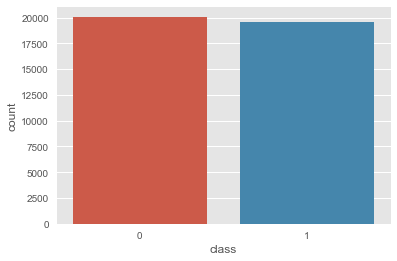

In [16]:
# distribucion del vector objetivo
sns.countplot(df['class'])

In [17]:
# columnas correlacion mayor a .8 a eliminar
correlasion_08 = df_correlaciones[(df_correlaciones['value'] >= 0.8)]
correlasion_08.sample(5, random_state = 15820)

,variable,var2,value
1499,kw_avg_avg,kw_max_avg,0.811864
1139,kw_avg_min,kw_max_min,0.940529
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852


In [18]:
list(set(df_correlaciones["variable"]) - set(df_correlaciones["var2"]))

['kw_max_max',
 'LDA_00',
 'kw_avg_avg',
 'rate_negative_words',
 'n_non_stop_unique_tokens',
 'LDA_04',
 'rate_positive_words',
 'min_negative_polarity',
 'kw_avg_min',
 'abs_title_sentiment_polarity',
 'max_positive_polarity',
 'self_reference_avg_sharess',
 'LDA_02',
 'is_weekend']

In [19]:
# Utilice esta celda para eliminar las variables altamente correlacionadas y la variable shares
#   Para identificar las variables con alta correlacion a eliminar utilice:
#      list(set(df_correlaciones["variable"]) - set(df_correlaciones["var2"]))
#   Guarde en una nueva variable X_mat el dataframe con las columnas eliminadas
#   Almacene en una variable y el vector objetivo class, que también se debe eliminar de X_mat

X_mat = df.drop(columns = ['kw_max_max',
                            'max_positive_polarity',
                            'kw_avg_min',
                            'LDA_04',
                            'abs_title_sentiment_polarity',
                            'rate_negative_words',
                            'n_non_stop_unique_tokens',
                            'kw_avg_avg',
                            'is_weekend',
                            'self_reference_avg_sharess',
                            'rate_positive_words',
                            'min_negative_polarity',
                            'LDA_00',
                            'LDA_02',
                            'class'])

In [20]:
X_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_words               39644 non-null  float64
 4   num_hrefs                      39644 non-null  float64
 5   num_self_hrefs                 39644 non-null  float64
 6   num_imgs                       39644 non-null  float64
 7   num_videos                     39644 non-null  float64
 8   average_token_length           39644 non-null  float64
 9   num_keywords                   39644 non-null  float64
 10  data_channel_is_lifestyle      39644 non-null  float64
 11  data_channel_is_entertainment  39644 non-null  float64
 12  data_channel_is_bus            39644 non-null 

In [21]:
# Utiliza esta celda para generar la división de muestras a partir de "X_mat" y de "y"
y = df['class']
y


0        0
1        0
2        1
3        0
4        0
        ..
39639    1
39640    1
39641    1
39642    0
39643    0
Name: class, Length: 39644, dtype: int32

- A continuación se detalla los pasos para implementar PCA "a mano". Alternativamente, si lo desea puede hacer una implementación con Pipeline, que se tendría que hacer en los ejercicios siguientes, para cada modelo / ensamble.

In [22]:
# Utiliza esta celda para estandarizar X_train (primero entrenando, y en otro paso transformando), ya que PCA funciona sobre datos estandarizados
#    NOTA: Las variables binarias no debiesen incluirse en la estandarización ni en el PCA
#    Considerando que es un ejercicio, en este caso las puede conservar incluyéndolas en la estandarización y en PCA
# Almacene los datos estandarizados en X_train_std
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components = 30))
X_mat = pca_pipe.fit_transform(X_mat)
# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
modelo_pca

PCA(n_components=30)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, random_state = 15820, test_size = .33)

In [24]:
# X_train PCA matriz de atributos de entrenamiento con los 30 componenetes principales dados por el PCA
X_train.shape

(26561, 30)

In [25]:
# X_train PCA matriz de atributos de validacion con los 30 componenetes principales dados por el PCA
X_test.shape

(13083, 30)

In [26]:
# PCA con 30 componentes sobre X_mat
modelo_pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29'], dtype=object)

### Ejercicio 2 - Evaluación de modelos individuales
- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    - Importe los módulos correctamente.
    - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision, Recall, F1. Puede hacer uso de la función `plot_classification_report` disponible en el archivo `helpers.py`.
    ```python
    plt.figure(figsize=(10, 10))
    for index, value in enumerate(estimators):
        plt.subplot(len(estimators), 1, index + 1)
        plt.title(value[0])
        class_pred = value[1].fit(X_train_pca, y_train).predict(X_test_pca)
        helpers.lot_classification_report(y_test, class_pred)
        plt.axvline(.5, label='.5 Boundary', linestyle='--')
        plt.xlim((0.1, 1.0))
        if (index + 1) % 2 == 0:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    ```
    - Comente el desempeño general de cada uno.
<br />
<br />


- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    - Regresión Logística.
    - K Nearest Neighbors con `n_neighbors=5`.
    ```python
    from sklearn.naive_bayes import GaussianNB
    nb = GaussianNB()
    ```
    - Árbol de Clasificación con un `max_depth=1`.
    - Árbol de Clasificación con un `max_depth=4`.

In [27]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Naives Bayes Gaussian', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state = rep_seed)),
            ('Decision Tree Classifier max_depth = 1', DecisionTreeClassifier(random_state = rep_seed, max_depth = 1)),
            ('Decision Tree Classifier max_depth = 4', DecisionTreeClassifier(random_state = rep_seed, max_depth = 4))]

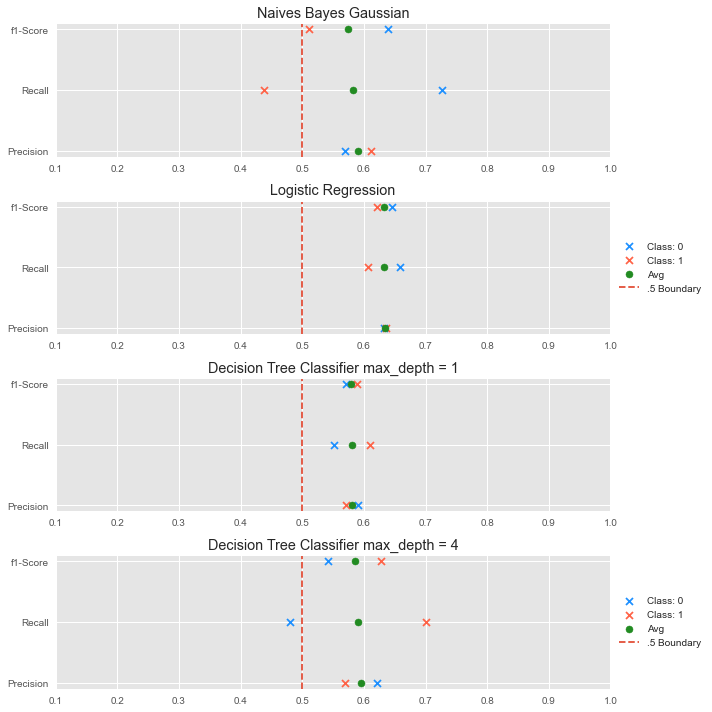

In [28]:
plt.figure(figsize = (10, 10))
for index, value in enumerate(estimators):
    plt.subplot(len(estimators), 1, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    gfx.plot_classification_report(y_test, class_pred)
    plt.axvline(.5, label = '.5 Boundary', linestyle = '--')
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.tight_layout()

Logistic regression presenta un mejor desempeño sobre los demas modelos, dado que tiene un comportamiento mas homogeneo a la prediccion de unos y ceros, ademas es el que mas se acerca al 100% de la prediccion.

Decision Tree Classifier con max_depth = 1, presenta el segundo mejor desempeño y un comportamiento similar a Logistic regression

Naives Bayes Gaussian y Decision Tree Classifier max_depth = 4, presentan las peores metricas destacando a Naives Bayes como el modelo con metricas mas debiles.

### Ejercicio 3 - Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.

In [29]:
# Utilice esta celda para entrenar VotingClassifier, y generar predicciones sobre X_test_pca
# VotingClassifier requiere de la lista de tuplas que definimos arriba
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

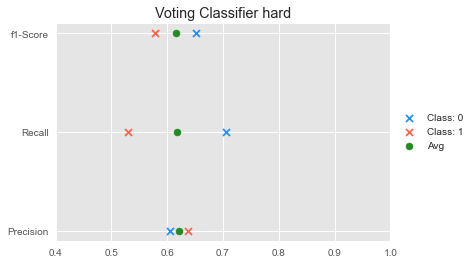

In [30]:
# Utilice esta celda para reportar desempeño utilizando helpers.plot_classification_report
gfx.plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test))
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier hard')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

### Ejercicio 4 - Calibración de Comité con Ponderadores
- En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo

In [31]:
# Utilice esta celda para definir los esquemas de pesos, definimos un diccionario con el esquema de ponderación a aplicar
weights_hyperparams = {'Esquema_1': [.166, .166, .166, .166],
                    'Esquema_2': [.125, .125, .20, .30]}

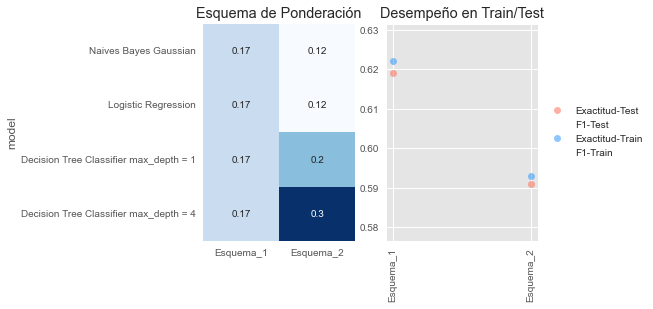

In [32]:
gfx.weighting_schedule(voting_classifier, X_train, X_test, y_train, y_test, weights_hyperparams)

Text(0.5, 1.0, 'Relevancia de cada clasificador en el ensamble')

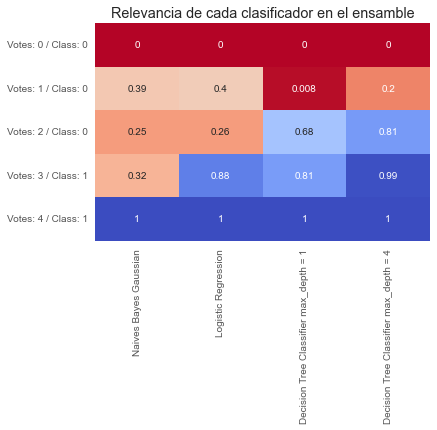

In [35]:
gfx.committee_voting(voting_classifier, X_train, X_test, y_train, y_test)
plt.title('Relevancia de cada clasificador en el ensamble')